Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: FILL IN YOUR NAMES HERE

# Neural Data Science Project 01

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [1]:
# import packages here
from pathlib import Path

import utils_project1 as utils

import numpy as np
import pandas as pd
import jupyter_black
import matplotlib.pyplot as plt
import matplotlib.patches as mp

jupyter_black.load()

## Context
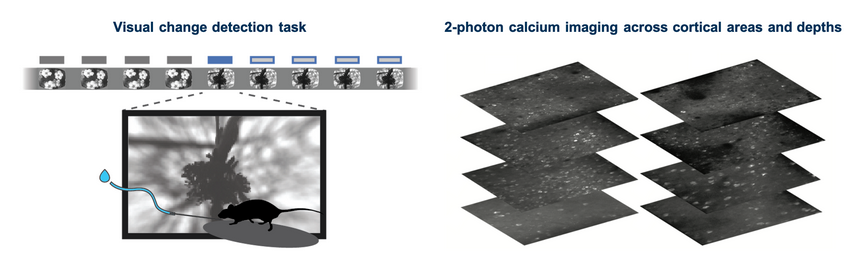

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

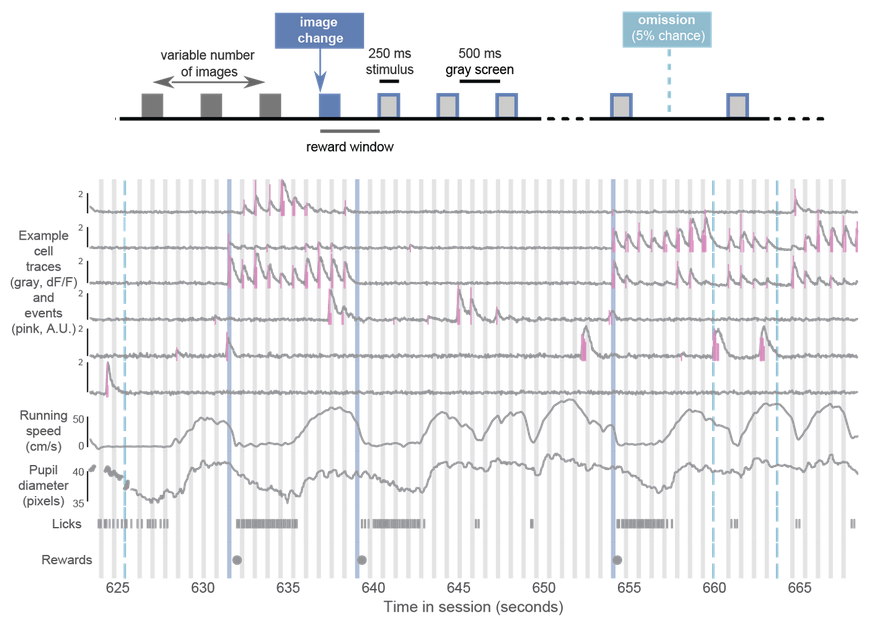

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [2]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    array2df(
        data,
        "stim_table",
        ["temporal_frequency", "orientation", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["stimulus", "start", "end"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data(path="../data/")
print(type(data))
print(data.keys())
print("Overview of the data")
print_info(data)
print(data["stim_epoch_table"])
print(data["stim_table"])
print(data["t"])

<class 'dict'>
dict_keys(['t', 'dff', 'stim_table', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table'])
Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)

              stimulus  start     end
0    drifting_gratings    747   18775
1  natural_movie_three  19709   37767
2    natural_movie_one  38671   47699
3    drifting_gratings  48602   66630
4          spontaneous  66780   75697
5  natural_movie_three  75698   93756
6    drifting_gratings  94659  115215
     temporal_frequency  orientation  blank_sweep     start       end
0                   1.0        225.0          0.0     747.0     807.0
1               

## Downloading OOPSI alogrithm for the spike inference 
* Link to the Github repository: https://github.com/liubenyuan/py-oopsi
* Link to the paper: http://stat.columbia.edu/~liam/research/pubs/vogelstein-fast.pdf 
    * published in: Journal of Neurophysiology, 104(6): 3691-3704

In [3]:
download_url = "https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py"
file_name = "oopsi.py"
if not Path(file_name).exists():
    !curl -L $download_url -o $file_name

import oopsi as ops

# Table of Content: 
###  [01. Data Exploration](#data_exploration)
*  #### [1.1 Distribution of sample size of displayed orientations](#displayedorientation)
*  #### [1.2 Sampling rate](#samplingrate)
*  #### [1.3 Displaying the roi masks](#maximum_projection)
*  #### [1.4 Displaying the dF/F traces](#displaydff)
*  #### [1.5 Visualizing example traces](#example_traces)
*  #### [1.6 Conclusion for data inspection:](#conclusion)
  
###  [02. Orientation selectiviy in dF/F](#orientation_selectivity)
*  #### [2.1 Polar plot of one ROI](#calcium_polar)
*  #### [2.2 How does the temporal resolution influence the orientation selectivity?](#temporal_influence)
###  [03. Transforming the calcium traces to spikes](#spike_inference)
*  #### [3.1 Thresholding the spike probability](#spike_threshold)
*  #### [3.2 Plotting the spikes on top of the DF/F](#spikes_on_df/f)
###  [04. Orientation selectiviy in spikes - tuning curves](#orientation_selectivity_spikes_tuning_curves)
###  [05. Orientation selectiviy in spikes - temporal frequency](#orientation_selectivity_spikes_tuning_curves_alternative)

# 1. Data Exploration <a class="anchor" id="data_exploration"></a>

## 1.1 Distribution of sample size of displayed orientations <a class="anchor" id="displayedorientation"></a>
As first step of the data exploration, we looked at the sample size of the trials for each orientation.
We found that the displayed orientations are not equally distributed. There are around 75 trials for each orientation and 30 trials for the blank stimulus (which is 5 % of the trials).

Orientations: [  0.  45.  90. 135. 180. 225. 270. 315.  nan],
Counts Orientation: [75 75 75 74 75 75 75 74 30]

Temporal Frequencies: [ 1.  2.  4.  8. 15. nan],
Counts Temporal Frequencies:[120 120 119 120 119  30]

Blank Sweeps: [0. 1.],
Counts Black Sweeps: [598  30]


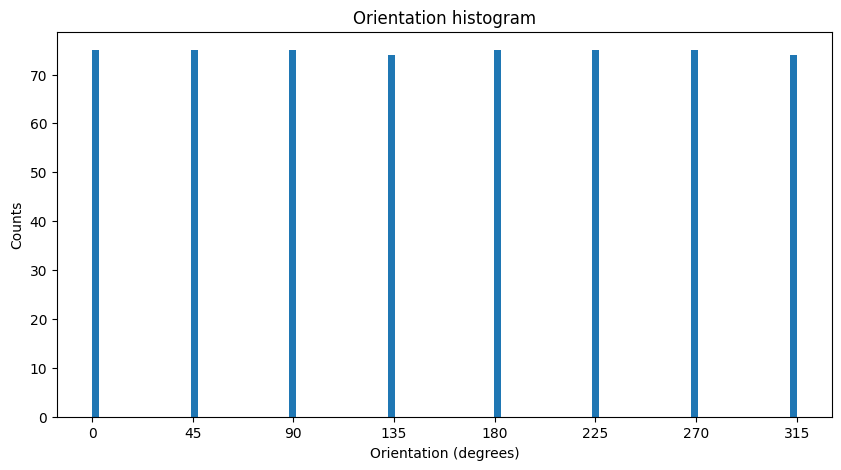

In [4]:
# ploting the orientation histogram
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(data["stim_table"]["orientation"], bins=100)
ax.set_xlabel("Orientation (degrees)")
ax.set_ylabel("Counts")
ax.set_title("Orientation histogram")
ax.set_xticks(np.arange(0, 360, 45))

# print out the unique values and their counts for orientation, temporal frequency and blank sweeps
uniq, coutnts = np.unique(data["stim_table"]["orientation"], return_counts=True)
print(f"Orientations: {uniq},\nCounts Orientation: {coutnts}\n")
freqs, counts_freqs = np.unique(
    data["stim_table"]["temporal_frequency"], return_counts=True
)
print(f"Temporal Frequencies: {freqs},\nCounts Temporal Frequencies:{counts_freqs}\n")
blanks, counts_blanks = np.unique(data["stim_table"]["blank_sweep"], return_counts=True)
print(f"Blank Sweeps: {blanks},\nCounts Black Sweeps: {counts_blanks}")

Then, we looked at the distribution throughout the epochs. We found that the sample size of trials for each displayed orientation are also not equally distributed across the three stimulus epochs. 

In [5]:
uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][:200],
    return_counts=True,
)

print(f"Orientations and counts for the first epoch: {uniq}, {coutnts}\n")

uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][200:400],
    return_counts=True,
)
print(f"Orientations and counts for the second epoch: {uniq}, {coutnts}\n")

uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][400:627],
    return_counts=True,
)
print(f"Orientations and counts for the third epoch: {uniq}, {coutnts}\n")

Orientations and counts for the first epoch: [  0.  45.  90. 135. 180. 225. 270. 315.  nan], [26 25 22 25 24 29 18 19 12]

Orientations and counts for the second epoch: [  0.  45.  90. 135. 180. 225. 270. 315.  nan], [23 26 19 22 21 22 28 27 12]

Orientations and counts for the third epoch: [  0.  45.  90. 135. 180. 225. 270. 315.  nan], [26 24 34 27 29 24 29 28  6]



## 1.2 Sampling rate <a class="anchor" id="samplingrate"></a>
We determined the sampling rate and the duration of the stimulus presentation, which are important for further analysis steps.
Sampling rate is around 30 Hz (30 frames per second), and the stimulus duration is 2 seconds long.

In [6]:
# the sampling rate:
print(f"Unique values of the sampling rate: {1 / np.unique(np.diff(data['t']))}")
# the stimulus time:
print(
    f'Stimulus time: {data["t"][data["stim_table"]["end"][0].astype(int)] - data["t"][data["stim_table"]["start"][0].astype(int)]}'
)

Unique values of the sampling rate: [30.07518797 30.07518797 30.07518797 30.07518797 30.07518797 30.07518797
 30.07518797 30.07518797 30.07518797 30.07518797 30.07518797 30.06614552
 30.06614552 30.06614552 30.06614552 30.06614552 30.06614552 30.06614552
 30.06614552 30.06614552 30.06614552]
Stimulus time: 1.9952200000000033


## 1.3 Maximum projection of the ROIs <a class="anchor" id="maximum_projection"></a>
To check if the ROI masks are segmented correctly, we plotted the maximum projection of the ROIs and the masks on top of it. The maximum projection is the maximum intensity value of each pixel in the z-stack. The maximum projection of the ROIs and the masks are shown in the figure below. The ROIs and the masks are segmented well. The ROIs are segmented in the correct location and the masks are segmented in the correct shape, judging from the maximum projection.

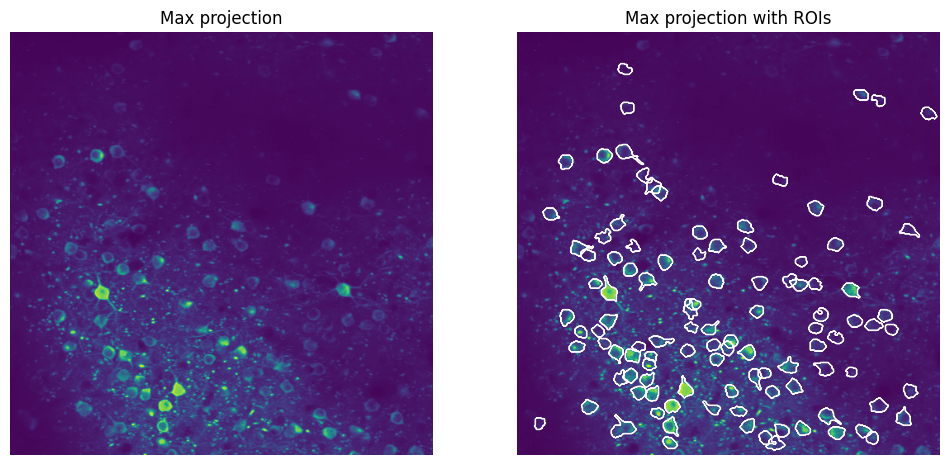

In [7]:
# plotting the max projection and the first ROI mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(data["max_projection"])
ax[1].imshow(data["max_projection"])

for i in range(len(data["roi_masks"][:, 0, 0])):
    plt.contour(data["roi_masks"][i, :, :], colors="white", linewidths=0.5)

ax[0].set_title("Max projection")
ax[1].set_title("Max projection with ROIs")
ax[0].axis("off")
ax[1].axis("off")
plt.show()

## 1.4 Displaying the dF/F traces <a class="anchor" id="displaydff"></a>
There are 106 different ROIs and to plot them nicely on top of each other we normalize them to the maximum value of the trace.
To visualize the stimulation phases, we used the start and stop times in the stim_epoch_table. The grey background indicates the start and stop times of the drifting grating presentation. 

In [8]:
# get the start and end times of the drifting grating stimulus
stimulusOF = "drifting_gratings"
drifting_df = data["stim_epoch_table"]["stimulus"] == stimulusOF
start_times = data["stim_epoch_table"]["start"][drifting_df].to_numpy().astype(int)
end_times = data["stim_epoch_table"]["end"][drifting_df].to_numpy().astype(int)

print(
    f'Durations of the drifting graiting stimulus per stimulus epoch: {data["t"][np.array(end_times)] - data["t"][np.array(start_times)]}'
)

Durations of the drifting graiting stimulus per stimulus epoch: [599.50393 599.52014 683.60274]


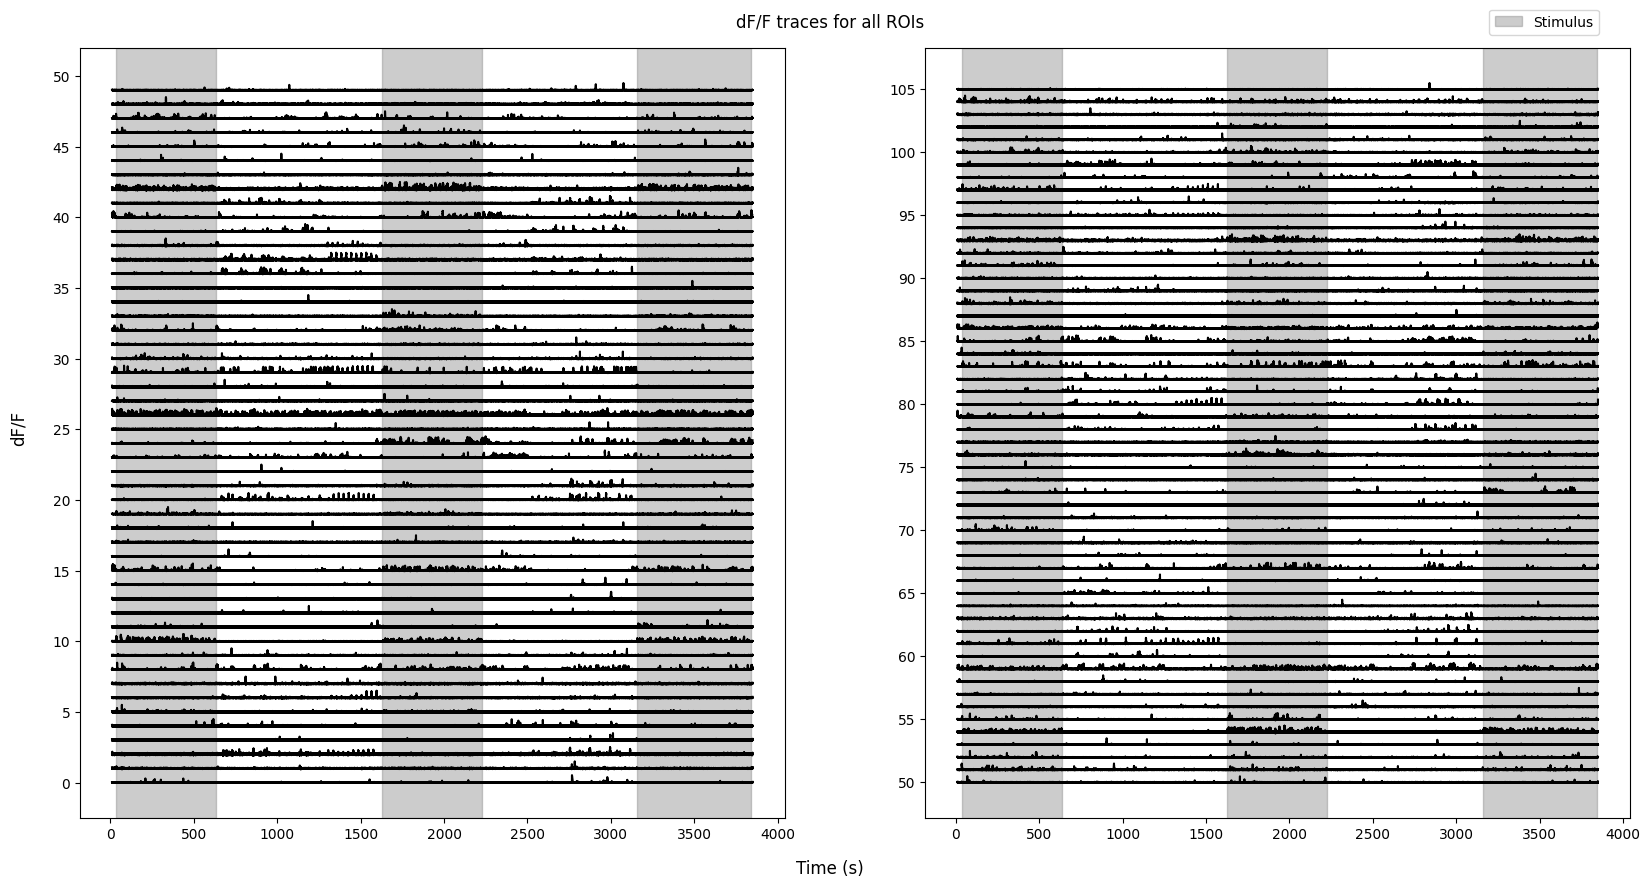

In [9]:
# ploting the dF/F traces for all ROIs with the stimulus times indicated in gray
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
for i in range(50):
    axs[0].plot(
        data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2, c="k"
    )
for i in range(50, 106):
    axs[1].plot(
        data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2, c="k"
    )
# plot the start and end times of the stimulus as gray areas
for i, s in enumerate(start_times):
    axs[0].axvspan(data["t"][s], data["t"][end_times[i]], alpha=0.4, color="gray")
    if i == 0:
        axs[1].axvspan(
            data["t"][s],
            data["t"][end_times[i]],
            alpha=0.4,
            color="gray",
            label="Stimulus",
        )
    else:
        axs[1].axvspan(data["t"][s], data["t"][end_times[i]], alpha=0.4, color="gray")

axs[0].set_yticks(np.arange(0, 101, 10))
axs[0].set_yticklabels(np.arange(0, 51, 5))
axs[1].set_yticks(np.arange(100, 212, 10))
axs[1].set_yticklabels(np.arange(50, 106, 5))
axs[1].legend(bbox_to_anchor=(0.8, 1.05), loc="upper left", borderaxespad=0.0)
fig.suptitle(
    "dF/F traces for all ROIs",
    x=0.5,
    y=0.915,
)
fig.supxlabel("Time (s)", x=0.5, y=0.05)
fig.supylabel("dF/F", x=0.09, y=0.5)
plt.show()

## 1.5 Visualizing example traces <a class="anchor" id="example_traces"></a>
We plotted three example traces of ROIs with high activity (10, 29, 54). We can see that the activity differed between three ROIs and that ROI 10 and 54 are more active during stimulation presentation and ROI 29 between the stimuli. This showed us, that we need to be careful in later analysis, that the ROIs are not more active inbetween the stimulation than during the stimulation.

In [10]:
# define a nice color palette
color_orientations = [
    "#271f7f",
    "#1565c0",
    "#009688",
    "#8bc34a",
    "#ffc107",
    "#ff9800",
    "#f44336",
    "#ad1457",
    "#000000",
]
color_temporal_frequencies = ["#9b5de5", "#f15bb5", "#fee440", "#00bbf9", "#00f5d4"]

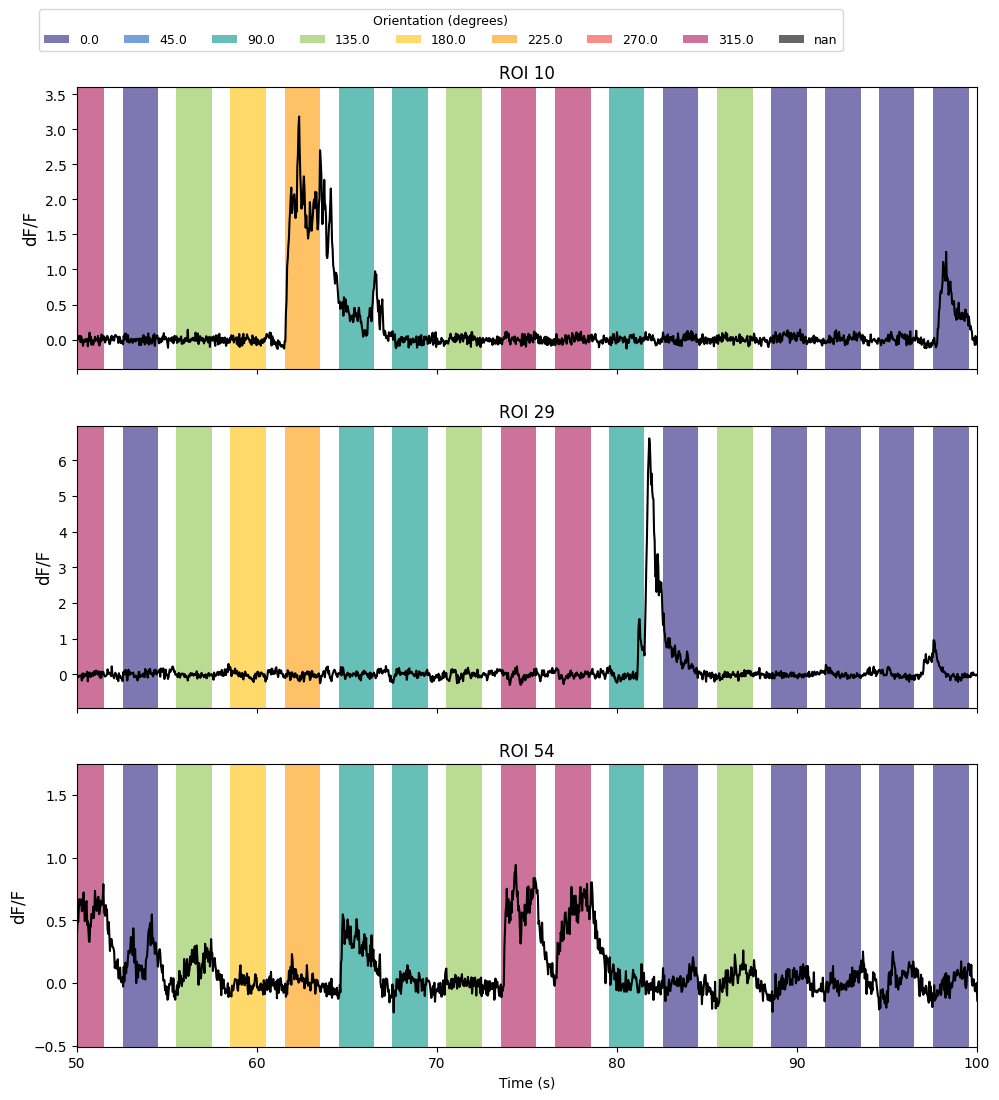

In [11]:
# define orientation and colors
orientations = np.sort(data["stim_table"]["orientation"].unique())
colors_orentation = np.zeros(len(data["stim_table"]["orientation"]), dtype=int)
for i, ori in enumerate(orientations):
    if i == 8:
        colors_orentation[data["stim_table"]["blank_sweep"] == 1] = i
    colors_orentation[data["stim_table"]["orientation"] == ori] = i

# define rois for the plot
rois = [
    10,
    29,
    54,
]

fig, axs = plt.subplots(len(rois), figsize=(12, 12), sharex=True)
plt.subplots_adjust(hspace=0.2, left=0.15, right=0.9, top=0.9, bottom=0.1)
# define xlim for the plot
limits = [50, 100]
for i, roi in enumerate(rois):
    axs[i].plot(data["t"], data["dff"][roi], c="k")
    for indx, (s, e) in enumerate(
        zip(
            data["t"][np.array(data["stim_table"]["start"], dtype=int)],
            data["t"][np.array(data["stim_table"]["end"], dtype=int)],
        )
    ):
        axs[i].axvspan(
            s,
            e,
            alpha=0.6,
            color=color_orientations[colors_orentation[indx]],
            lw=0,
        )
    orientation_patches = [
        mp.Rectangle(
            (0, 0),
            1,
            1,
            fc=color_orientations[i],
            alpha=0.6,
            angle=orientations[i],
        )
        for i in range(9)
    ]

    axs[i].set_xlim(limits)
    axs[i].set_title(f"ROI {roi}")
    axs[i].set_ylabel("dF/F", fontsize=12)
axs[i].set_xlabel("Time (s)")

axs[0].legend(
    orientation_patches,
    orientations,
    bbox_to_anchor=(0.0, 1.2),
    loc="center left",
    borderaxespad=-3,
    fontsize=9,
    title="Orientation (degrees)",
    title_fontsize=9,
    ncol=9,
)
plt.show()

## 1.6 Conclusion for data inspection: <a class="anchor" id="conclusion"></a>
1. The sample size of the trials for each orientation in each stimulus epoch is not equally distributed.
2. The sampling rate for this project is 30 Hz. 
3. In the calcium trace data, we can clearly see the activity of the ROIs in response to the stimulus.
4. In ROI 29 we can see that the cell is spiking inbetween the trials, and we need to handle this. 

# 2. Orientation selectivity in the dF/F traces <a class="anchor" id="orientation_selectivity"></a>

As a control for the spike inference which we want to do later, we looked at the mean dF/F for each orientation per ROI. We will later use this to visually check if the spike inference resulted in reasonable results.

## 2.1 Polar plot of one ROI <a class="anchor" id="calcium_polar"></a>

To show the tuning of the ROI, we plotted polar plots for one example ROI. For this we calculated the mean dF/F per orientation with the corresponding standard deviation.

In [12]:
# define x axis for the polar plots (in radians)
orientations_polar_plot = np.deg2rad(
    np.sort(
        data["stim_table"]["orientation"].unique()[
            ~np.isnan(data["stim_table"]["orientation"].unique())
        ]
    )
)

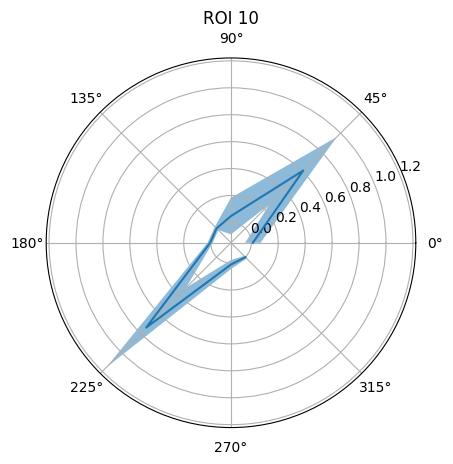

In [13]:
# caluclate the mean and std of the calcium response for each orientation for each roi
# see utils_project1.py for the functions dff_orientation

mean_calcium_orientation, std_calcium_orientation = utils.dff_orientation(data)

# define the ROI for the plot
roi = 10
# plot a polar plot for for each orientation
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})

ax.plot(
    orientations_polar_plot,
    mean_calcium_orientation[roi, :],
)
ax.fill_between(
    orientations_polar_plot,
    mean_calcium_orientation[roi, :] - std_calcium_orientation[roi, :],
    mean_calcium_orientation[roi, :] + std_calcium_orientation[roi, :],
    alpha=0.5,
)
ax.set_title(f"ROI {roi}")
plt.show()

## 2.2 How does the temporal frequency of the stimulus influence the orientation selectivity? <a class="anchor" id="temporal_influence"></a>

To explore the influence of the temporal frequency of the stimulus on the orientation selectivity of the ROIs, we plotted the mean calcium activity per orientation for each temporal frequency for one example ROI in polar plots. This showed us that the temporal frequency influences the orientation selectivity of the ROIs. Knowing this, we later analyzed the influence of the temporal frequency on the orientation selectivity of the ROIs in more detail.

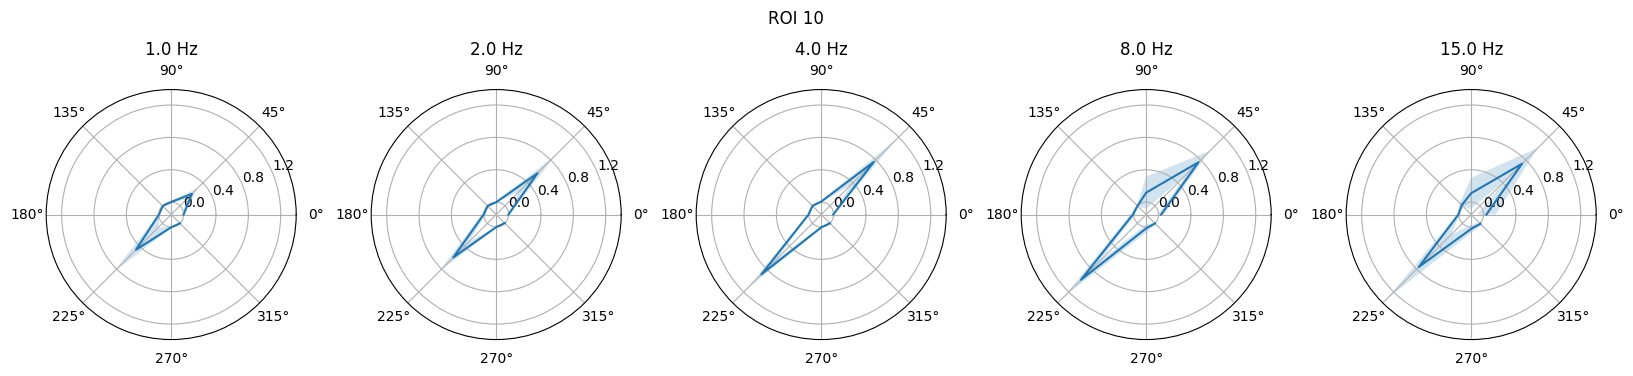

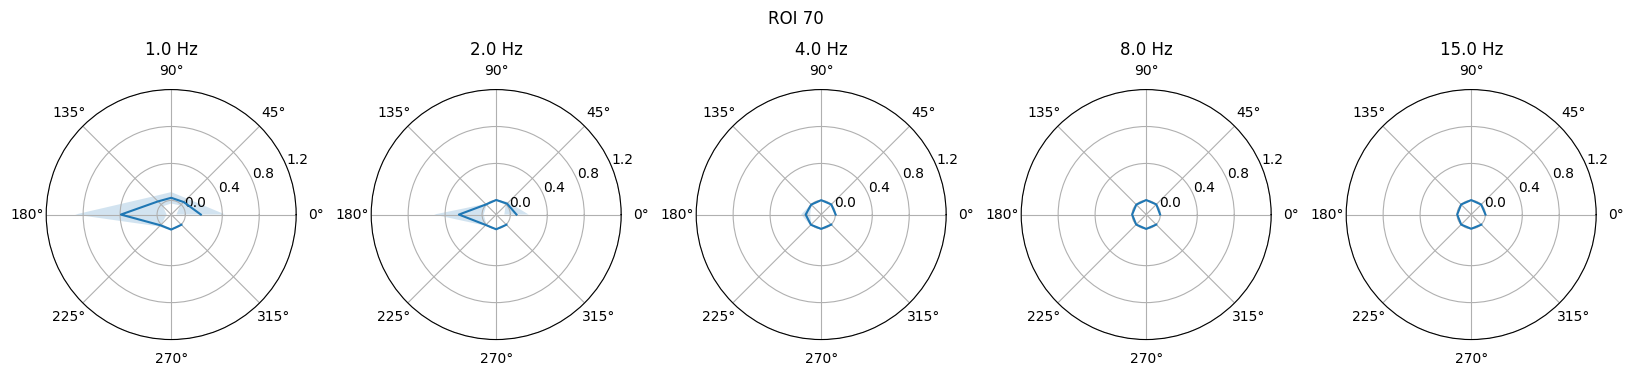

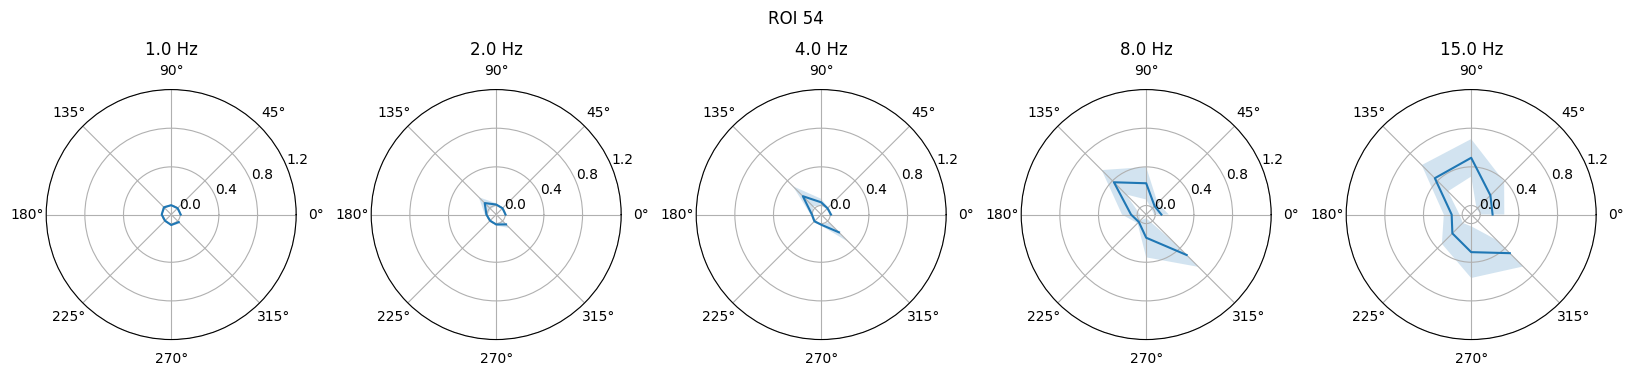

In [14]:
(
    mean_calcium_orientation_temp,
    std_calcium_orientation_temp,
) = utils.dff_orientation_temporal_frequency(data)
temporal_frequencies = data["stim_table"]["temporal_frequency"].unique()
temporal_frequencies = np.sort(temporal_frequencies[~np.isnan(temporal_frequencies)])

# selct a roi
rois = [10, 70, 54]
for roi in rois:
    # plot a polar plot for for each orientation and temporal frequency
    fig, axs = plt.subplots(
        1, 5, subplot_kw={"projection": "polar"}, figsize=(20, 10), sharey=True
    )
    plt.subplots_adjust(wspace=0.3)
    for i, ax in enumerate(axs.flat):
        ax.plot(
            orientations_polar_plot,
            mean_calcium_orientation_temp[roi, :, i],
        )
        # add std to the plot
        ax.fill_between(
            orientations_polar_plot,
            mean_calcium_orientation_temp[roi, :, i]
            - std_calcium_orientation_temp[roi, :, i],
            mean_calcium_orientation_temp[roi, :, i]
            + std_calcium_orientation_temp[roi, :, i],
            alpha=0.2,
        )
        ax.set_title(f"{temporal_frequencies[i]} Hz")
        ax.set_yticks(np.arange(0, 1.5, 0.4))
        fig.suptitle(f"ROI {roi}", y=0.70)
plt.show()

# 3. Transforming the calcium traces to spikes <a class="anchor" id="spike_inference"></a>
To infere spikes from the calcium traces we used the algorithm from coding lab 3, py-oopsi. 

In [15]:
# check if spike data is already saved
data_path = Path("../data")

# create the data path if it does not exist
data_path.mkdir(exist_ok=True)
# load the data
if Path(data_path / "spike_data.npy").exists():
    spike_data = np.load("../data/spike_data.npy")
else:
    spike_data = np.zeros((data["dff"].shape[0], data["dff"].shape[1]))
    for roi in range(data["dff"].shape[0]):
        # initialize the paraparameters for the oopsi algorithm
        F, P = ops.oopsi_init_par(data["dff"][roi], 1 / 30)
        n, C, post = ops.oopsi_est_map(F, P)
        print(n.shape)
        print(roi)
        spike_data[roi] = n
    np.save("../data/spike_data.npy", spike_data)

## 3.1 Thresholding the spike probability <a class="anchor" id="spike_threshold"></a>
The oopsi algorithm returns the probability of a spike occurring at each time point. We can use a threshold to decide whether a spike has occurred or not. The returned spike probability is a value between 0 and 1. After visual assessment of the spike data compared to the calcium traces, we chose a threshold of 0.2.


In [16]:
# thershold the spike data at get the time points where the spike occurs
threshold = 0.2
spike_data[spike_data < threshold] = 0
spike_data[spike_data >= threshold] = 1
spike_data = spike_data.astype(int)
# get the spike times for each ROI
spike_times = []
for roi in range(spike_data.shape[0]):
    spike_times.append(data["t"][spike_data[roi, :] >= 0.5])
spike_times = np.array(spike_times, dtype=object)

## 3.2 Plotting the spikes on top of the DF/F <a class="anchor" id="spikes_on_df/f"></a>
We then plotted the spikes above the calcium traces to make sure that the thresholding was done correctly. We also plotted the spikes on top of the calcium traces to make sure that the spikes were aligned with the calcium traces.

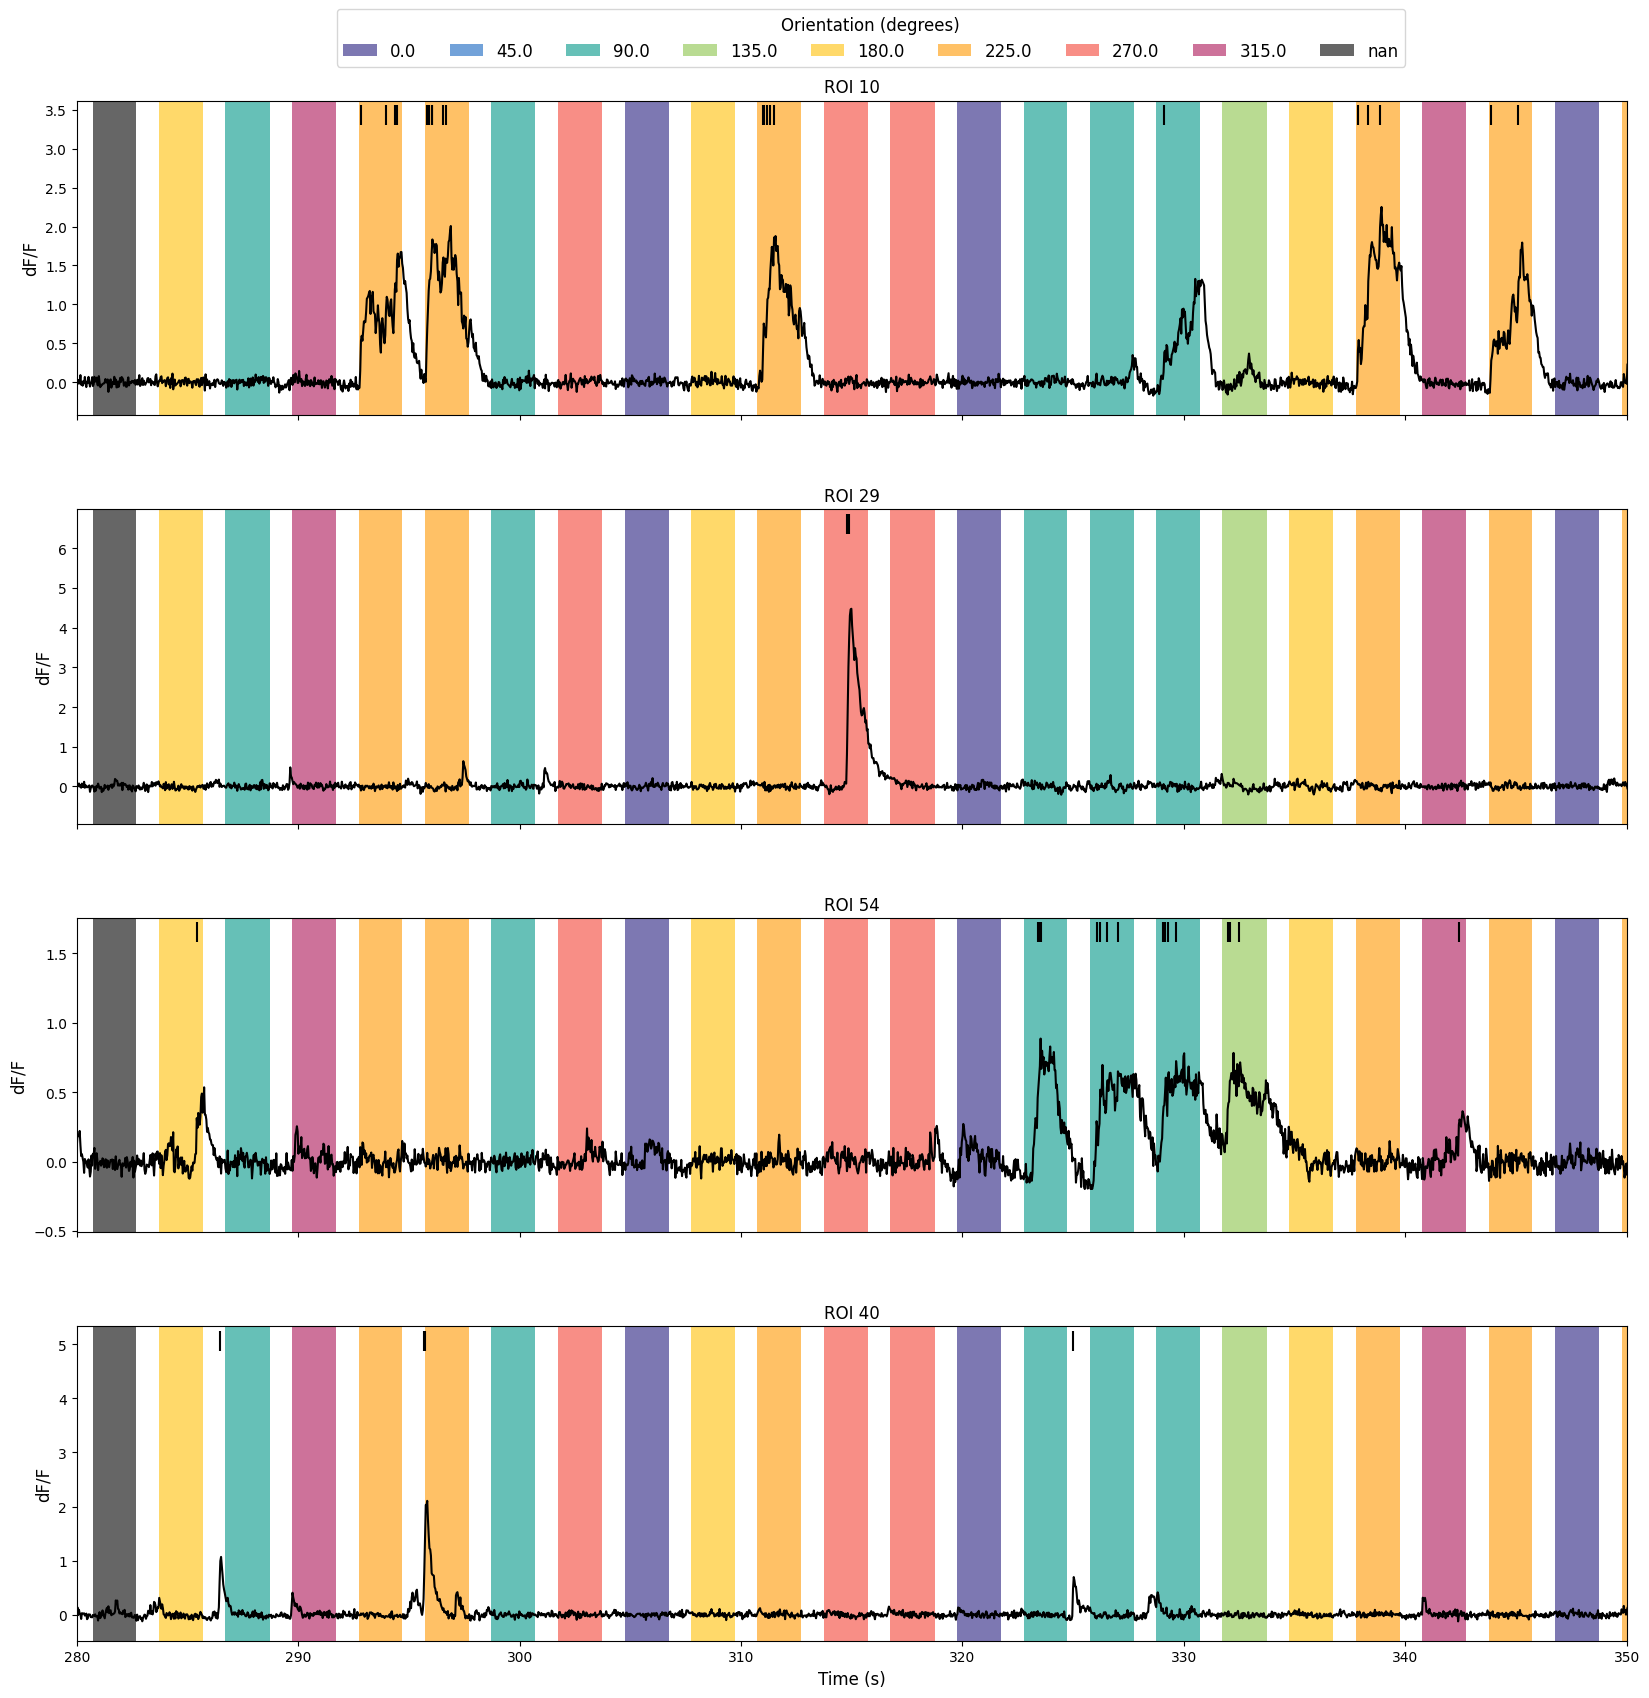

In [17]:
orientations = np.sort(data["stim_table"]["orientation"].unique())
colors_orentation = np.zeros(len(data["stim_table"]["orientation"]), dtype=int)
for i, ori in enumerate(orientations):
    if i == 8:
        colors_orentation[data["stim_table"]["blank_sweep"] == 1] = i
    colors_orentation[data["stim_table"]["orientation"] == ori] = i

rois = [10, 29, 54, 40]

fig, axs = plt.subplots(len(rois), figsize=(20, 20), sharex=True)
plt.subplots_adjust(hspace=0.3)

limits = [280, 350]
for i, roi in enumerate(rois):
    axs[i].plot(data["t"], data["dff"][roi], c="k")
    axs[i].scatter(
        spike_times[roi],
        np.ones(len(spike_times[roi])) * np.max(data["dff"][roi]) + 0.01,
        c="k",
        marker="|",
        s=200,
        zorder=10,
    )
    for indx, (s, e) in enumerate(
        zip(
            data["t"][np.array(data["stim_table"]["start"], dtype=int)],
            data["t"][np.array(data["stim_table"]["end"], dtype=int)],
        )
    ):
        axs[i].axvspan(
            s,
            e,
            alpha=0.6,
            color=color_orientations[colors_orentation[indx]],
            linewidth=0,
        )
    orientation_patches = [
        mp.Rectangle(
            (0, 0),
            1,
            1,
            fc=color_orientations[i],
            alpha=0.6,
            angle=orientations[i],
        )
        for i in range(9)
    ]

    axs[i].set_xlim(limits)
    axs[i].set_title(f"ROI {roi}")
    axs[i].set_ylabel("dF/F", fontsize=12)
axs[i].set_xlabel("Time (s)", fontsize=12)


axs[0].legend(
    orientation_patches,
    orientations,
    bbox_to_anchor=(0.2, 1.2),
    loc="center left",
    borderaxespad=-3,
    fontsize=12,
    title="Orientation (degrees)",
    title_fontsize=12,
    ncol=9,
)
plt.show()

# 4. Choosing orientation selective cells with permutation test

Before testing cells for orientation or direction selectivity, we first filtered the dataset to only get cells that are active in the right periods. We did this by looking at the mean activity of the cells in the stimulus presentation period. 

We only chose cells that had at least 75% of their activity in the stimulus presentation period. We chose 75% as our
threshold because at 50% we can't be sure if the ROI is reacting to the stimulus. 

We also excluded cells that had no activity at all. 

As an additional criterion, we only chose cells that had at least one spike in at least 5 trials for at least one orientation. This was necessary because otherwise we would have had a lot of false positives in the permutation testing.

## 4.1 Applying restrictions / filtering the data

In [18]:
# orientation selctivity to rois that have at leat 5 trials where the neuron fired for at least one orientation
# calculate the p value for each roi
p_dirs = np.ones(data["dff"].shape[0], dtype=float)

rois_sum = np.sum(spike_data, axis=1) > 0
qualifying_rois = np.where(rois_sum)[0]
rois_active = []

for roi in qualifying_rois:
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    counts_direction_unique = [
        len(np.where(counts[dirs == d] > 0)[0]) for d in np.unique(dirs)
    ]
    empty_check = np.array(counts_direction_unique) >= 5
    if np.sum(empty_check) > 0:
        rois_active.append(roi)

print("Preliminary number of ROIs that are orientation selective: ", len(rois_active))
print(rois_active)

Preliminary number of ROIs that are orientation selective:  27
[5, 10, 11, 18, 19, 29, 33, 40, 42, 46, 48, 50, 51, 52, 54, 55, 61, 67, 70, 77, 83, 84, 91, 97, 99, 100, 102]


In [19]:
# Calculating the spike counts for each ROI inbetween the stimulus
counts_inbetween = np.zeros(data["dff"].shape[0], dtype=object)
start_times_inbetween = data["stim_table"]["end"].to_numpy().astype(int)
end_times_inbetween = data["stim_table"]["start"].to_numpy().astype(int)[1:]

for roi in range(data["dff"].shape[0]):
    idx_spikes = np.where(spike_data[roi] == 1)[0]
    counts_inbetween_roi = []
    for i, (s, e) in enumerate(zip(start_times_inbetween, end_times_inbetween)):
        ori = data["stim_table"]["orientation"][i]
        if np.isnan(ori):
            continue
        counts_inbetween_roi.append(np.sum((idx_spikes >= s) & (idx_spikes <= e)))
    counts_inbetween[roi] = np.sum(np.array(counts_inbetween_roi))

In [20]:
# Exclude rois that have less than 75% of their spikes in the stimulus

qualifying_rois_snr = []
for roi in rois_active:
    dirs, counts_stim = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    counts_inb = counts_inbetween[roi]
    # check if 75% of the total spikes are in the stimulus
    if np.sum(counts_stim) / (counts_inb + np.sum(counts_stim)) >= 0.75:
        qualifying_rois_snr.append(roi)
print(f"These ROIs qualify for further analysis: {qualifying_rois_snr}")
print(f"Number of ROIs that qualify: {len(qualifying_rois_snr)}")

These ROIs qualify for further analysis: [10, 19, 33, 42, 51, 52, 54, 55, 70, 84, 91, 102]
Number of ROIs that qualify: 12


In the next step, we do a permutation test for the first Fourier component of the stimulus to test for direction selectivity and for the second Fourier component to test for orientation selectivity.

In [21]:
# Direction
# calculate the permutation of the qualifying rois
rois_sig_direction = []
for roi in qualifying_rois_snr:
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    p = utils.testTuning(counts, dirs, psi=1, niters=1000)[0]
    if p < 0.01:
        rois_sig_direction.append(roi)
print(
    f"These ROIs are significant in direction: {rois_sig_direction}, total {len(rois_sig_direction)} ROIs"
)

# Orientation
# calculate the permutation of the qualifying rois
rois_sig_orientation = []
for roi in qualifying_rois_snr:
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    p = utils.testTuning(counts, dirs, psi=2, niters=1000)[0]
    if p < 0.01:
        rois_sig_orientation.append(roi)
print(
    f"These ROIs are significant in orientation: {rois_sig_orientation}, total {len(rois_sig_orientation)} ROIs"
)

These ROIs are significant in direction: [10, 19, 33, 42, 51, 54, 55, 70, 84, 91, 102], total 11 ROIs
These ROIs are significant in orientation: [10, 19, 33, 42, 51, 55, 70, 84, 91, 102], total 10 ROIs


As you can see, we have approximately the same number of direction and orientation selective ROIs and the lists contain many overlapping ROIs. Only ROI 54 is exclusively direction selective.

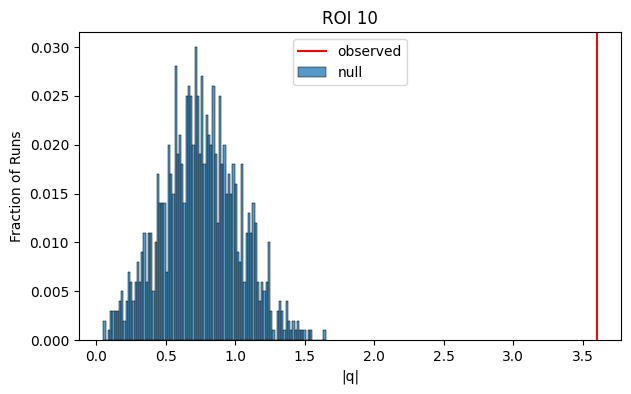

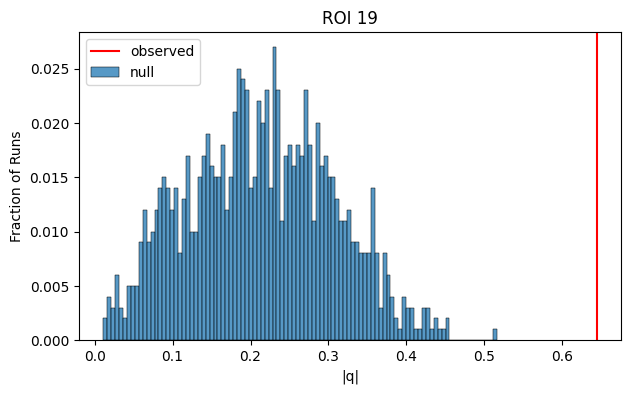

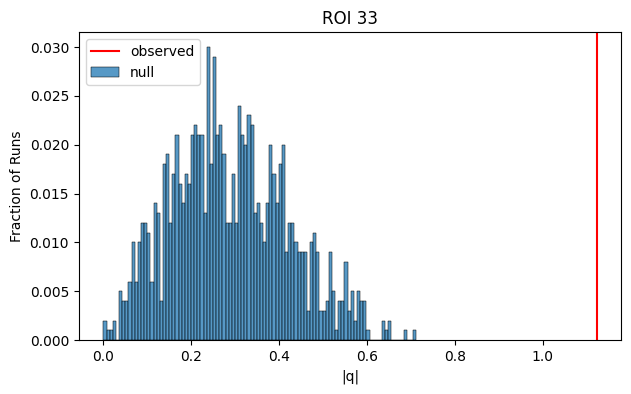

In [22]:
# show the permutation test for the first 3 direction selective ROIs
rois = rois_sig_orientation

for roi in rois[:3]:
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    utils.testTuning(
        counts, dirs, psi=1, niters=1000, show=True, title_name=f"ROI {roi}"
    )

## 4.2 Plotting the tuning curves for the orientation selective ROIs 

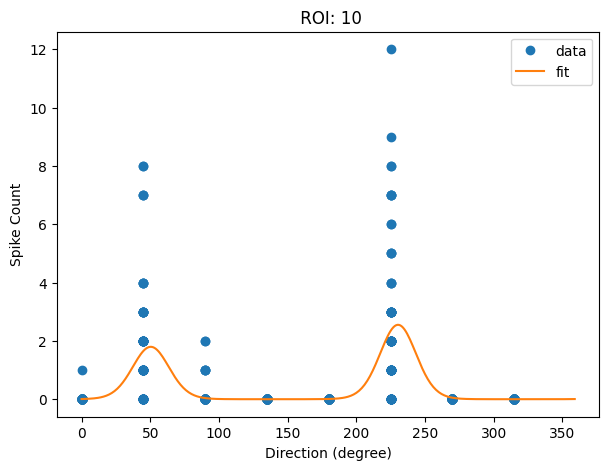

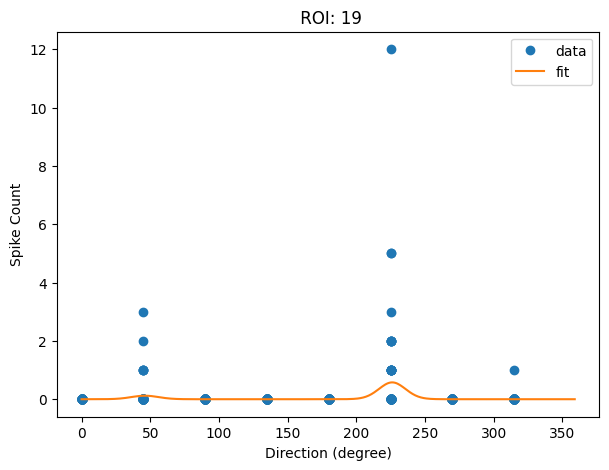

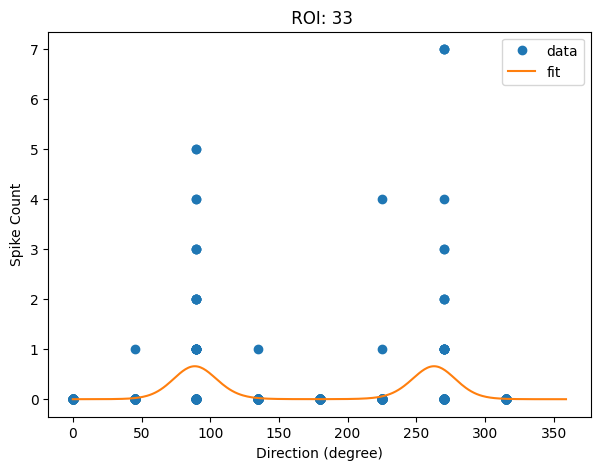

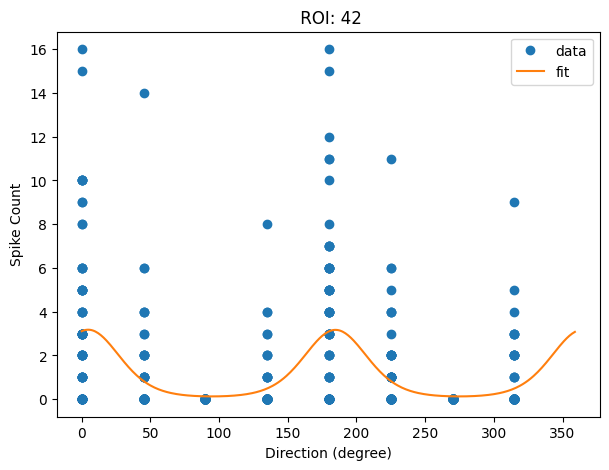

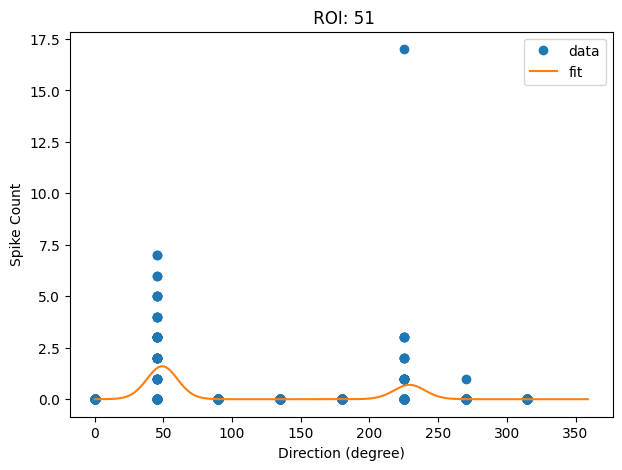

In [23]:
for roi in rois[:5]:
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    utils.tuningCurve(counts, dirs, show=True, tile_name=f" ROI: {roi}")

In [24]:
# q = (2.5, 97.5)
# (
#     median_spikes,
#     spike_orientation_percentile_lower,
#     spike_orientation_percentile_upper,
# ) = utils.spike_orientation_median(data, spike_data, q)

In [25]:
# # plot a polar plot for for each orientation
# roi = 54
# fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})

# ax.plot(
#     orientations_polar_plot,
#     median_spikes[roi, :],
# )


# ax.fill_between(
#     orientations_polar_plot,
#     spike_orientation_percentile_lower[roi, :],
#     spike_orientation_percentile_upper[roi, :],
#     alpha=0.5,
#     zorder=-1,
# )

# print(orientations_polar_plot)
# print(
#     spike_orientation_percentile_lower[roi, :],
#     spike_orientation_percentile_upper[roi, :],
# )
# ax.set_title(f"ROI {roi}")

In [54]:
(
    median_spikes_temp,
    lower_spikes_temp,
    upper_spikes_temp,
) = utils.spike_orientation_temporal_median(data, spike_data, q)

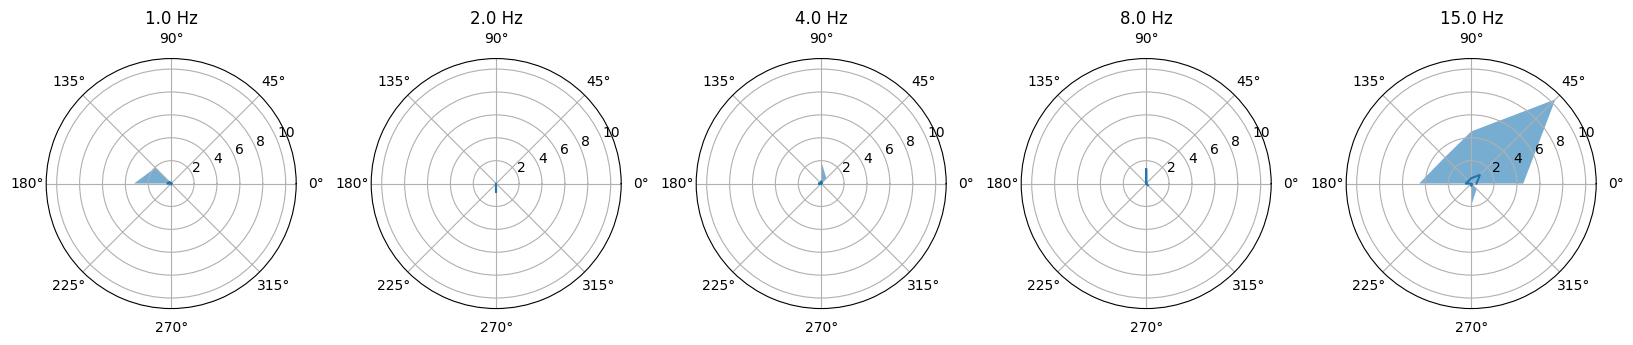

In [56]:
fig, axs = plt.subplots(
    1, 5, subplot_kw={"projection": "polar"}, figsize=(20, 10), sharey=True
)
roi = 67
plt.subplots_adjust(wspace=0.3)
for i, ax in enumerate(axs.flat):
    ax.plot(
        orientations_polar_plot,
        median_spikes_temp[roi, :, i],
    )
    # add std to the plot
    ax.fill_between(
        orientations_polar_plot,
        lower_spikes_temp[roi, :, i],
        upper_spikes_temp[roi, :, i],
        alpha=0.6,
    )
    ax.set_title(f"{temporal_frequencies[i]} Hz")

In [28]:
# orientations = np.sort(data["stim_table"]["orientation"].unique())
# colors_orentation = np.zeros(len(data["stim_table"]["orientation"]), dtype=int)
# for i, ori in enumerate(orientations):
#     if i == 8:
#         colors_orentation[data["stim_table"]["blank_sweep"] == 1] = i
#     colors_orentation[data["stim_table"]["orientation"] == ori] = i

# rois_plotting = 3

# fig, axs = plt.subplots(len(rois[:rois_plotting]), figsize=(20, 10), sharex=True)
# plt.subplots_adjust(hspace=0.3)
# limits = [0, 300]
# for i, roi in enumerate(rois[:rois_plotting]):
#     axs[i].plot(data["t"], data["dff"][roi], c="k")
#     for indx, (s, e) in enumerate(
#         zip(
#             data["t"][np.array(data["stim_table"]["start"], dtype=int)],
#             data["t"][np.array(data["stim_table"]["end"], dtype=int)],
#         )
#     ):
#         axs[i].axvspan(
#             s,
#             e,
#             alpha=0.6,
#             color=colors_list[colors_orentation[indx]],
#         )
#     orientation_patches = [
#         mp.Rectangle(
#             (0, 0),
#             1,
#             1,
#             fc=colors_list[i],
#             alpha=0.6,
#             angle=orientations[i],
#         )
#         for i in range(9)
#     ]

#     axs[i].set_xlim(limits)
#     axs[i].set_title(f"ROI {roi}")


# axs[0].legend(
#     orientation_patches,
#     orientations,
#     bbox_to_anchor=(0.2, 1.32),
#     loc="center left",
#     borderaxespad=-3,
#     fontsize=12,
#     title="Orientation (degrees)",
#     title_fontsize=12,
#     ncol=9,
# )

In [29]:
# # plot a polar plot for for each orientation
# for roi in rois[:rois_plotting]:
#     fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})
#     ax.plot(
#         orientations_polar_plot,
#         median_spikes[roi, :],
#     )
#     print(median_spikes[roi, :])
#     print(spike_orientation_percentile_lower[roi, :])
#     print(spike_orientation_percentile_upper[roi, :])
#     # add std to the plot
#     ax.fill_between(
#         orientations_polar_plot,
#         spike_orientation_percentile_lower[roi, :],
#         spike_orientation_percentile_upper[roi, :],
#         alpha=1,
#     )
#     ax.set_yticks(np.arange(0, 5, 1))
#     ax.set_title(f"ROI {roi}")

# 5. Temporal frequency analysis
* maby we sorted out the ROIs that have a significant response to the stimulus.


In [30]:
# permutation test for the temporal frequency tuning

temporal_frequencies = data["stim_table"]["temporal_frequency"].unique()
temporal_frequencies = np.sort(temporal_frequencies[~np.isnan(temporal_frequencies)])

p_dirs_temporal = np.zeros((data["dff"].shape[0], len(temporal_frequencies)))

for i, roi in enumerate(range(data["dff"].shape[0])):
    for j, freq in enumerate(temporal_frequencies):
        dirs, counts = utils.get_spike_counts_per_orientation_temporalfreq(
            data, spike_data, roi, freq
        )
        p_dirs_temporal[i, j] = utils.testTuning(
            counts, dirs, psi=1, niters=1000, show=False
        )[0]

r, t = np.where(p_dirs_temporal < 0.01)
print("Number of ROIs with significant temporal frequency tuning: %d" % len(r))
print(r, t)

Number of ROIs with significant temporal frequency tuning: 71
[  7  10  10  10  10  10  11  11  12  19  19  19  20  21  29  33  33  33
  40  42  42  42  46  46  48  48  50  50  50  51  51  51  51  54  54  54
  54  55  55  61  63  64  67  67  70  70  71  77  77  77  77  77  78  81
  84  84  84  91  91  91  91  96  96  97  97  97  98 100 100 102 104] [2 0 1 2 3 4 0 4 0 0 1 2 1 0 0 2 3 4 3 2 3 4 0 1 3 4 0 1 3 0 1 2 3 1 2 3 4
 0 1 2 0 1 1 3 0 1 0 0 1 2 3 4 0 3 0 1 2 1 2 3 4 2 4 0 1 2 0 1 4 4 0]


plotting how many are significant for the each temporat frequency, but there is a problem with false positives, because the data is zero inflated. 

Text(0.5, 1.0, 'Significant temporal frequencies')

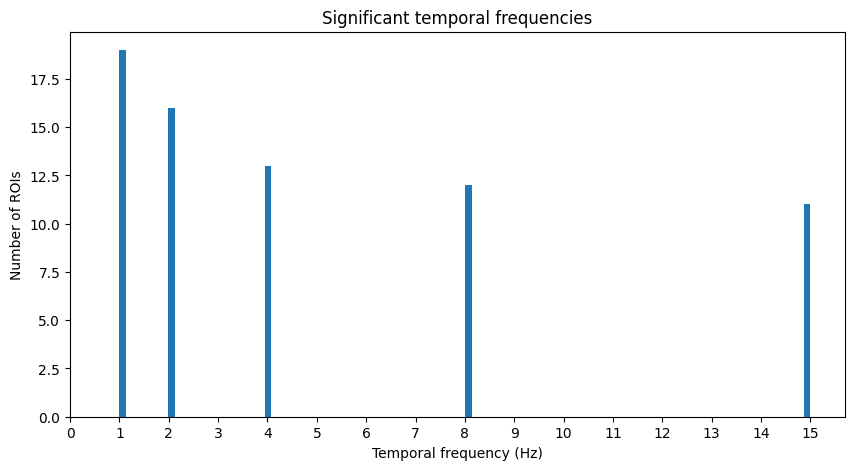

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(temporal_frequencies[t], bins=100)
ax.set_xticks(np.arange(0, 16, 1))
ax.set_xlabel("Temporal frequency (Hz)")
ax.set_ylabel("Number of ROIs")
ax.set_title("Significant temporal frequencies")

In [32]:
q = (2.5, 97.5)
(
    median_spikes_temp,
    lower_spikes_temp,
    upper_spikes_temp,
) = utils.spike_orientation_temporal_median(data, spike_data, q)

In [33]:
rois_idx, temp_idx = np.where(median_spikes_temp[r, :, t] > 1)

print(
    f"Rois in which at least one temporal frequency is significant:\n {np.unique(r[rois_idx])}"
)
print(f"Rois that are overall significant:\n {rois_sig_orientation}")

Rois in which at least one temporal frequency is significant:
 [ 10  19  33  42  46  51  54  55  67  70  77  91 102]
Rois that are overall significant:
 [10, 19, 33, 42, 51, 55, 70, 84, 91, 102]


Text(0, 0.5, 'Number of ROIs')

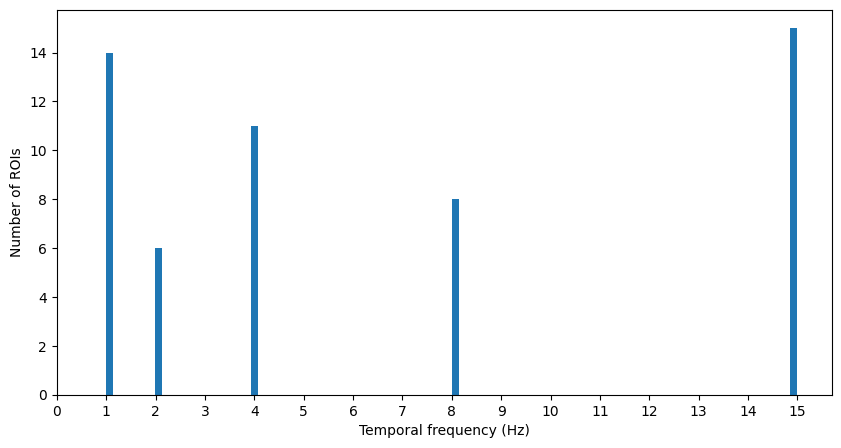

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(temporal_frequencies[t[temp_idx]], bins=100)
ax.set_xticks(np.arange(0, 16, 1))
ax.set_xlabel("Temporal frequency (Hz)")
ax.set_ylabel("Number of ROIs")

In [35]:
# for roi in np.unique(r[rois_idx]):
#     fig, axs = plt.subplots(
#         1, 5, subplot_kw={"projection": "polar"}, figsize=(20, 10), sharey=True
#     )
#     plt.subplots_adjust(wspace=0.3)
#     for i, ax in enumerate(axs.flat):
#         ax.plot(
#             orientations_polar_plot,
#             median_spikes_temp[roi, :, i],
#         )
#         # add std to the plot
#         ax.fill_between(
#             orientations_polar_plot,
#             lower_spikes_temp[roi, :, i],
#             upper_spikes_temp[roi, :, i],
#             alpha=1,
#         )
#         ax.set_title(f"{temporal_frequencies[i]} Hz")
#     fig.suptitle(f"ROI {roi}", x=0.5, y=0.7)

In [66]:
median_spikes_temp[102, 1, :]

array([0.        , 0.        , 0.        , 0.33333333, 1.66666667])

In [68]:
print(np.where(median_spikes_temp > 1))

(array([ 10,  10,  10,  10,  10,  10,  10,  10,  19,  33,  33,  42,  42,
        42,  42,  42,  42,  42,  42,  42,  42,  42,  46,  46,  51,  51,
        51,  51,  52,  54,  54,  54,  54,  54,  54,  54,  54,  54,  54,
        54,  54,  54,  55,  55,  67,  67,  70,  70,  77,  77,  77,  91,
        91,  91,  91, 102]), array([1, 1, 1, 1, 5, 5, 5, 5, 5, 2, 6, 0, 0, 0, 1, 3, 4, 4, 4, 5, 5, 7,
       2, 6, 1, 1, 1, 5, 0, 0, 1, 2, 2, 3, 3, 3, 5, 6, 6, 7, 7, 7, 0, 0,
       1, 2, 4, 4, 2, 5, 5, 0, 4, 4, 4, 1]), array([1, 2, 3, 4, 0, 2, 3, 4, 1, 2, 4, 2, 3, 4, 4, 4, 2, 3, 4, 3, 4, 4,
       0, 0, 0, 1, 2, 0, 0, 4, 4, 3, 4, 2, 3, 4, 4, 3, 4, 2, 3, 4, 0, 1,
       4, 3, 0, 1, 4, 2, 3, 2, 1, 2, 4, 4]))


In [38]:
median_spikes_temp[10, 1, :]

array([0.26666667, 1.33333333, 2.46666667, 1.93333333, 2.26666667])

In [39]:
t

array([2, 0, 1, 2, 3, 4, 0, 4, 0, 0, 1, 2, 1, 0, 0, 2, 3, 4, 3, 2, 3, 4,
       0, 1, 3, 4, 0, 1, 3, 0, 1, 2, 3, 1, 2, 3, 4, 0, 1, 2, 0, 1, 1, 3,
       0, 1, 0, 0, 1, 2, 3, 4, 0, 3, 0, 1, 2, 1, 2, 3, 4, 2, 4, 0, 1, 2,
       0, 1, 4, 4, 0])

In [40]:
temp_idx

array([5, 1, 1, 5, 1, 5, 1, 5, 5, 2, 6, 0, 4, 0, 4, 5, 0, 1, 3, 4, 5, 7,
       2, 6, 1, 5, 1, 1, 3, 7, 2, 3, 6, 7, 0, 1, 2, 3, 5, 6, 7, 0, 0, 2,
       4, 4, 5, 5, 2, 4, 0, 4, 4, 1])

In [41]:
r

array([  7,  10,  10,  10,  10,  10,  11,  11,  12,  19,  19,  19,  20,
        21,  29,  33,  33,  33,  40,  42,  42,  42,  46,  46,  48,  48,
        50,  50,  50,  51,  51,  51,  51,  54,  54,  54,  54,  55,  55,
        61,  63,  64,  67,  67,  70,  70,  71,  77,  77,  77,  77,  77,
        78,  81,  84,  84,  84,  91,  91,  91,  91,  96,  96,  97,  97,
        97,  98, 100, 100, 102, 104])

In [42]:
rois_idx

array([ 1,  2,  3,  3,  4,  4,  5,  5, 10, 15, 17, 19, 19, 20, 20, 20, 21,
       21, 21, 21, 21, 21, 22, 22, 29, 29, 30, 31, 34, 34, 35, 35, 35, 35,
       36, 36, 36, 36, 36, 36, 36, 37, 38, 43, 44, 45, 49, 50, 51, 57, 58,
       58, 60, 69])

In [43]:
r[np.unique(rois_idx)]

array([ 10,  10,  10,  10,  10,  19,  33,  33,  42,  42,  42,  46,  51,
        51,  51,  54,  54,  54,  55,  55,  67,  70,  70,  77,  77,  77,
        91,  91,  91, 102])

In [44]:
temporal_frequencies[t[temp_idx]]

array([15.,  1.,  1., 15.,  1., 15.,  1., 15., 15.,  2.,  1.,  4.,  8.,
        4.,  8., 15.,  4.,  1.,  4.,  8., 15., 15.,  2.,  1.,  1., 15.,
        1.,  1.,  4., 15.,  2.,  4.,  1., 15.,  4.,  1.,  2.,  4., 15.,
        1., 15.,  4.,  4.,  2.,  8.,  8., 15., 15.,  2.,  8.,  4.,  8.,
        8.,  1.])

In [45]:
temporal_frequencies

array([ 1.,  2.,  4.,  8., 15.])

In [46]:
t[temp_idx]

array([4, 0, 0, 4, 0, 4, 0, 4, 4, 1, 0, 2, 3, 2, 3, 4, 2, 0, 2, 3, 4, 4,
       1, 0, 0, 4, 0, 0, 2, 4, 1, 2, 0, 4, 2, 0, 1, 2, 4, 0, 4, 2, 2, 1,
       3, 3, 4, 4, 1, 3, 2, 3, 3, 0])

In [60]:
temporal_frequencies[t[r == 10]]

array([ 1.,  2.,  4.,  8., 15.])

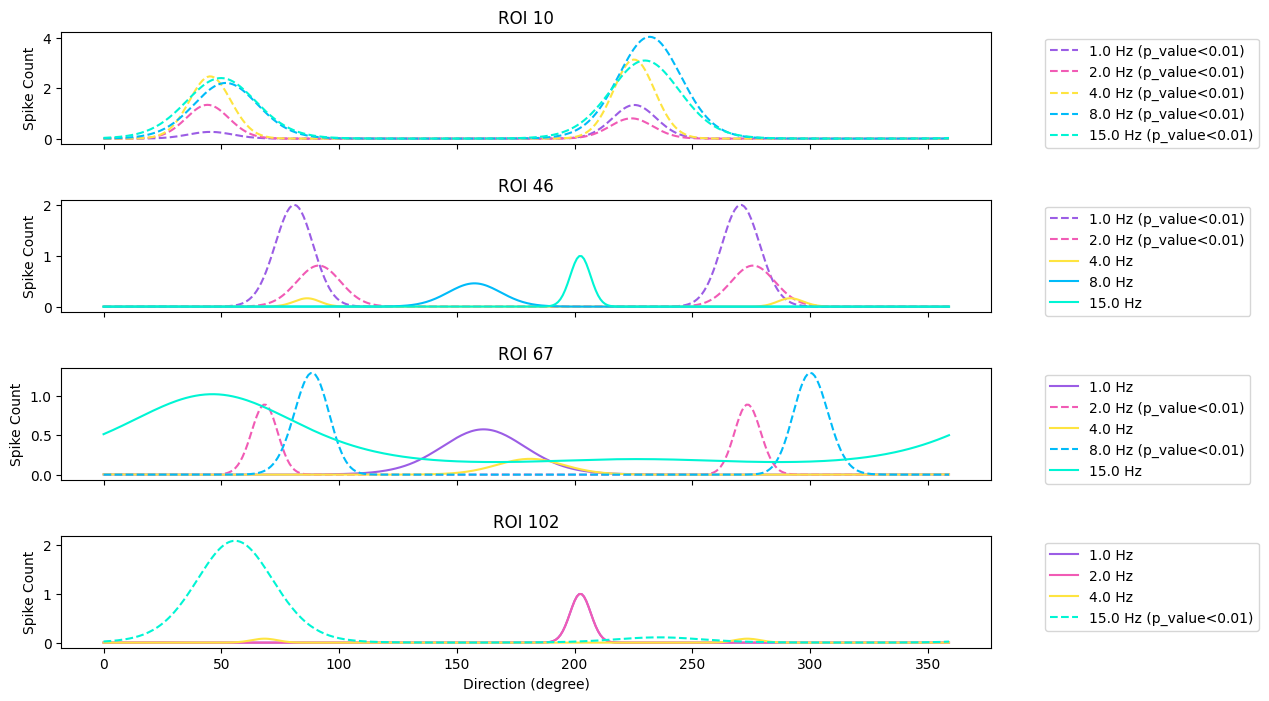

In [63]:
# Tuning curves with respect to the temporal frequency of the drifting grating
plotting_rois = [10, 46, 67, 102]
fig, ax = plt.subplots(len(plotting_rois), figsize=(12, 8), sharex=True)
plt.subplots_adjust(hspace=0.5)
for i, roi in enumerate(plotting_rois):
    for j, freq in enumerate(temporal_frequencies):
        dirs, counts = utils.get_spike_counts_per_orientation_temporalfreq(
            data, spike_data, roi, freq
        )
        _, x, y = utils.tuningCurve(
            counts,
            dirs,
            show=False,
        )
        if y is None:
            continue
        if roi in r and freq in temporal_frequencies[t[r == roi]]:
            ax[i].plot(
                x,
                y,
                label=f"{freq} Hz (p_value<0.01)",
                color=color_temporal_frequencies[j],
                linestyle="dashed",
            )
        else:
            ax[i].plot(x, y, label=f"{freq} Hz", color=color_temporal_frequencies[j])

        ax[i].set_ylabel("Spike Count")
        ax[i].set_title(f"ROI {roi}")
        ax[i].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax[-1].set_xlabel("Direction (degree)")

# 6. Plotting the PSTH for orientation/direction selective ROIs

In [48]:
orientations = data["stim_table"]["orientation"].unique()
orientations = np.sort(orientations[~np.isnan(orientations)])
SpikeTable_df = pd.DataFrame(columns=rois)
instant_firing_rate_df = pd.DataFrame(columns=rois, index=orientations)

prestim = 15  # index
poststim = 15
time_window = prestim + poststim + 59

for j, l in enumerate(rois):
    SpikeTable = np.zeros((len(data["stim_table"]["start"]), time_window))
    for i in range(len(data["stim_table"]["start"])):
        starts = data["stim_table"]["start"][i]
        ends = data["stim_table"]["end"][i]
        # not the exact same length for each trial
        if len(spike_data[l][int(starts) - prestim : int(ends) + poststim]) >= 90:
            difference = (
                len(spike_data[l][int(starts) - prestim : int(ends) + poststim])
                - time_window,
            )[0]
            SpikeTable[i, :] = spike_data[l][
                int(starts) - prestim : int(ends) + poststim - difference
            ]
        else:
            SpikeTable[i, :] = spike_data[l][
                int(starts) - prestim : int(ends) + poststim
            ]
    SpikeTable = np.array(SpikeTable, dtype=object)
    SpikeTable_df[l] = [SpikeTable]
    for m, orientation in enumerate(orientations):
        instant_firing_rate_df[l][m] = (
            np.nanmean(
                SpikeTable_df[l][0][
                    data["stim_table"]["orientation"] == orientation, :
                ],
                axis=0,
            )
            * 30
        )

# smooth the firing rates 
smoothed_firing_rates = utils.smooth_rate(data, instant_firing_rate_df[10], 7)

/var/folders/6f/4s63gb612m185fbsprljhfmh0000gn/T/ipykernel_35895/3154431301.py:31: FutureWarning: Treating integers as positional in Series.__setitem__ with a Float64Index is deprecated. In a future version, `series[an_int] = val` will insert a new key into the Series. Use `series.iloc[an_int] = val` to treat the key as positional.
  instant_firing_rate_df[l][m] = (
/Users/acfw/Documents/uni_tuebingen/neuraldatascience/notebooks/utils_project1.py:549: RuntimeWarning: Mean of empty slice
  smoothed_rate[i, j] = np.nanmean(


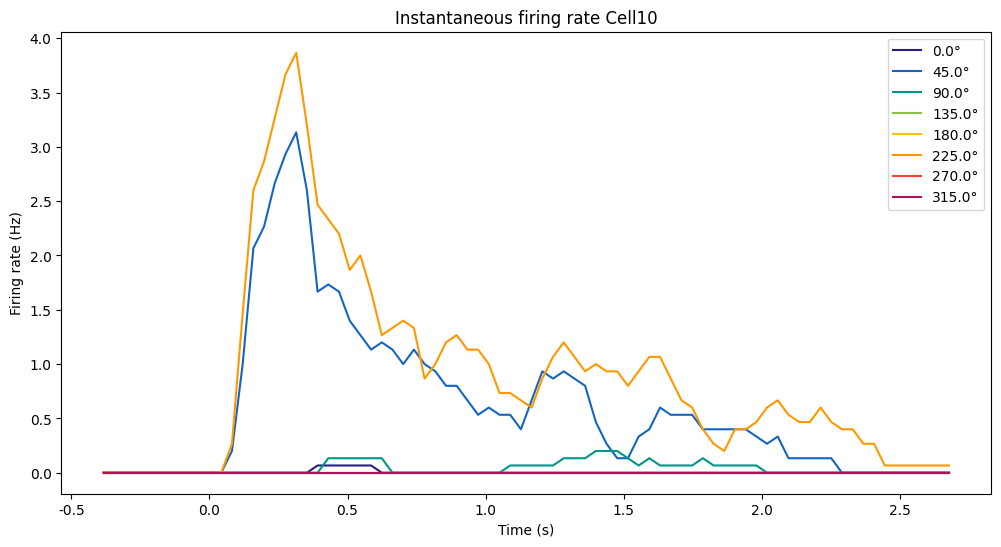

In [49]:
# plot instant rates and tuning curve in one plot
fig, axs = plt.subplots(1, figsize=(12, 6))
for i in range(len(orientations)):
    axs.plot(
        np.arange(len(smoothed_firing_rates[0])) / 30,
        smoothed_firing_rates[i],
        label=f"{orientations[i]}°",
        color=color_orientations[i],
    )

axs.set_title("Instantaneous firing rate Cell10")
axs.set_xlabel("Time (s)")
axs.set_ylabel("Firing rate (Hz)")
axs.set_xticks(np.arange(0, 90, 12.9) / 30)
axs.set_xticklabels(np.arange(-0.5, 3, 0.5))
axs.legend()
plt.show()

## Plotting the spatial structure of orientation selective rois

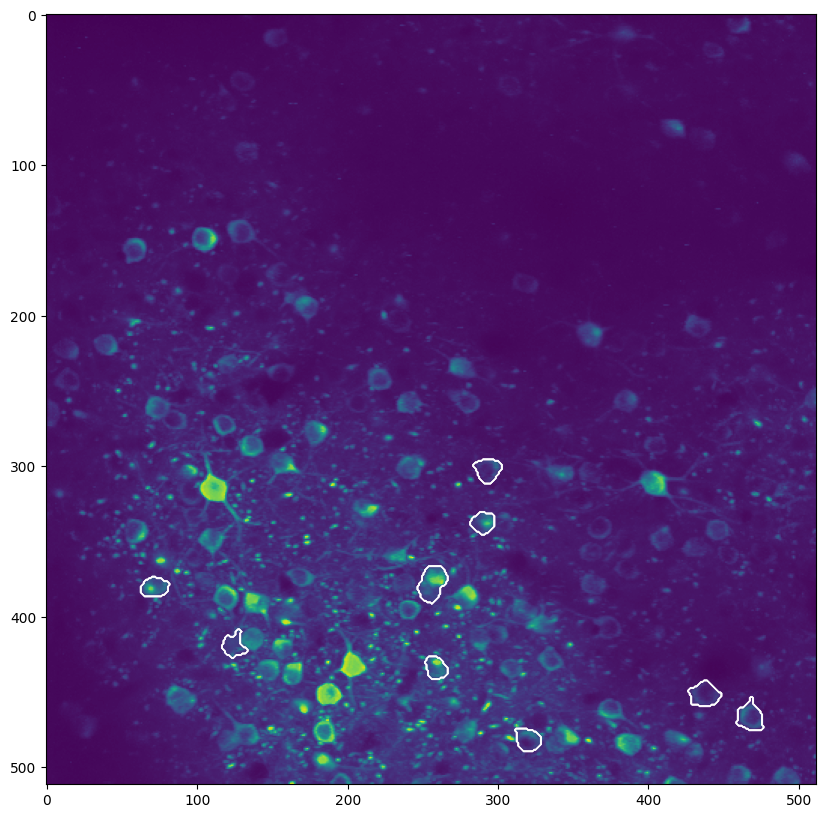

In [50]:
matrix = np.zeros((data["roi_masks"].shape[1], data["roi_masks"].shape[2]))
for roi in rois:
    x, y = np.where(data["roi_masks"][roi, :, :] != 0)
    matrix[x, y] = 1

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(data["max_projection"])
ax.contour(matrix, alpha=1, colors="white", linewidths=0.5)
ax.set_title("")
plt.show()

NameError: name 'median_spikes' is not defined

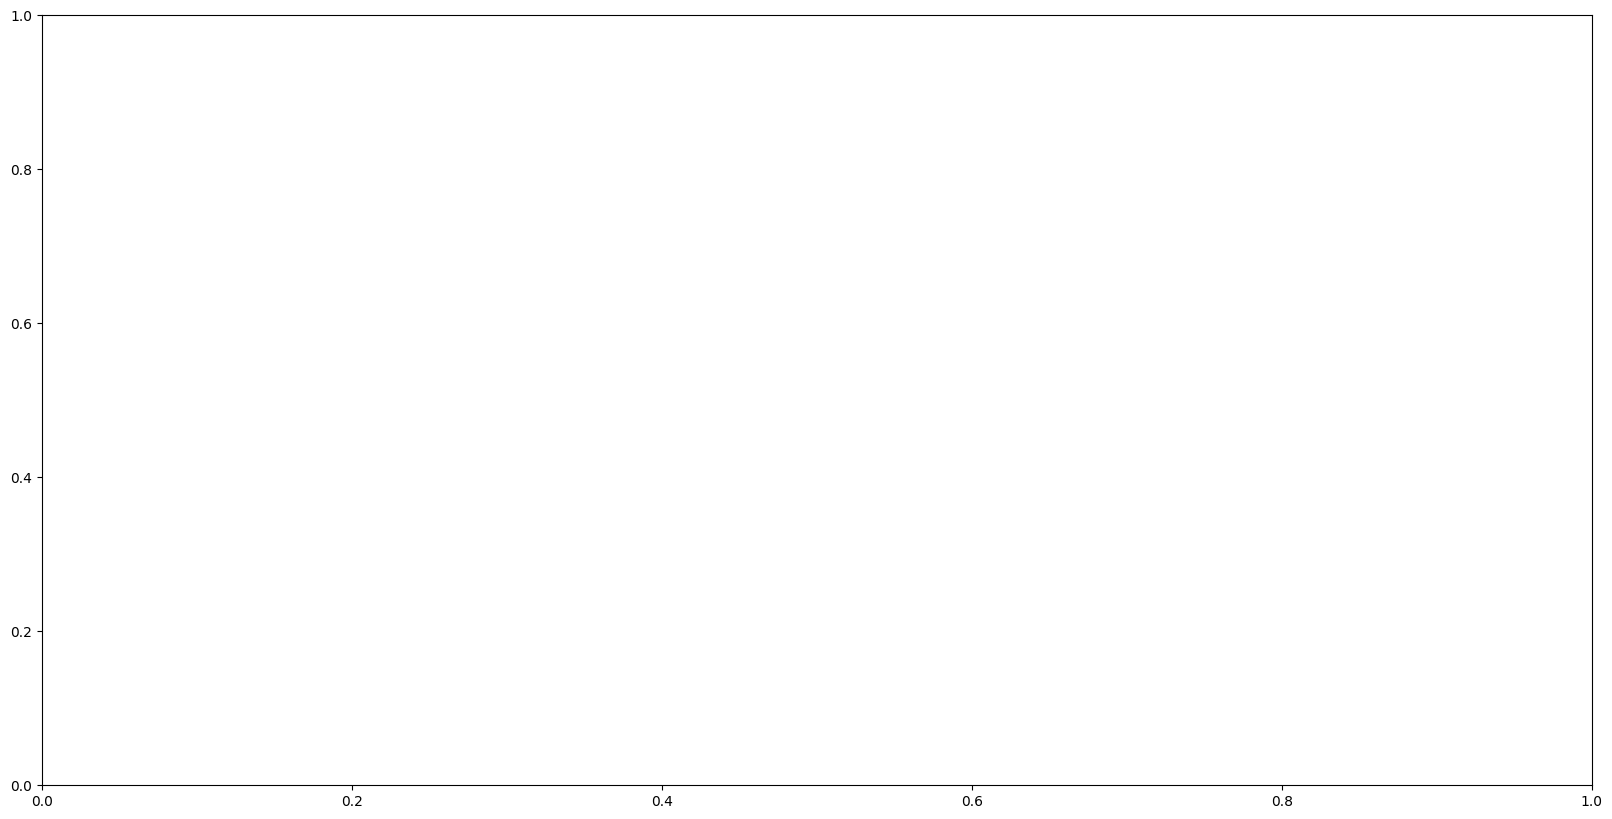

In [51]:
colors_list_masks = [
    "#271f7f",
    "#009688",
    "#ffc107",
    "#f44336",
]

fig, ax = plt.subplots(figsize=(20, 10))
for roi in rois:
    # plot the roi mask as scatter plot
    x, y = np.where(data["roi_masks"][roi, :, :] == 1)
    maxima_orientation = np.argmax(median_spikes[roi, :])
    print(maxima_orientation)
    if maxima_orientation > 3:
        maxima_orientation = maxima_orientation - 4
        print(f"after: {maxima_orientation}")

    ax.scatter(x, y, s=10, c=colors_list_masks[maxima_orientation], alpha=0.6)
    # invert the y axis

ax.set_xlim(0, 512)[::-1]
ax.set_ylim(0, 512)[::-1]
plt.show()

## Question

**Is there spatial structure in the preferred orientation/direction/spatial frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 
5. Temporal frequencies?
6. Do neighbouring cells share the same orientation?

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.